In [1]:
import numpy as np
from subprocess import call
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from math import isnan

In [2]:
def get_matrix(pi1, pi2, q1, q2, l, sol_index=1):
    '''
    sol_index=1: the program that finds the solution always gets the good one on the second row of the file (when verbosity -v)
    '''
    r1, r2 = 1/q1, 1/q2
    # first get the stationary f0:
    call(f'python f0poly_sols_clean.py {pi1} {pi2} {q1} {q2} {l} -v > sols.dat', shell=True)
    sols = []
    with open('sols.dat', 'r') as file:
        for line in file.readlines():
            sols_i = [float(f) for f in line.split()]
            sols.append(sols_i)
    f0 = sols[sol_index][0]
    a11 = l*f0-r1-(1-l)*pi1*(1+l/(r1/f0-l))
    a12 = -pi1*(1-l)*(1+l/(r1/f0-l))
    a21 = -pi2*(1-l)*(1+l/(r2/f0-l))
    a22 = l*f0-r2-(1-l)*pi2*(1+l/(r2/f0-l))
    a = np.array([[a11,a12], [a21, a22]])
    return a

def get_matrix_sol_spec(pi1, pi2, q1, q2, l, f0):
    '''
    provide the values of f0
    '''
    r1, r2 = 1/q1, 1/q2
    a11 = l*f0-r1-(1-l)*pi1*(1+l/(r1/f0-l))
    a12 = -pi1*(1-l)*(1+l/(r1/f0-l))
    a21 = -pi2*(1-l)*(1+l/(r2/f0-l))
    a22 = l*f0-r2-(1-l)*pi2*(1+l/(r2/f0-l))
    a = np.array([[a11,a12], [a21, a22]])
    return a

In [14]:
pi1, pi2, q1, q2, l = 0.00001, 0.00001, 10, 10, 0.05
a = get_matrix(pi1, pi2, q1, q2, l, sol_index=0)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

a = get_matrix(pi1, pi2, q1, q2, l, sol_index=1)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

# a = get_matrix_sol_spec(pi1, pi2, q1, q2, l, f0=0.1)
# print(np.linalg.eig(a)[0])
# eigs = np.linalg.eig(a)[0]

[5.00569713e-02 3.79855764e-05]
[-0.05001899 -0.05005697]


In [42]:
np.linalg.eig(a)

(array([-0.83054487,  0.04198367]),
 array([[-0.99656366,  0.68900161],
        [ 0.08283037, -0.72475981]]))

In [41]:
np.linalg.eig(a)[1][:,0]

array([-0.99656366,  0.08283037])

In [5]:
1/eigs[1]**2

1.7820703482314584

## f0 stability case q1=q2, pi1=pi2

In [15]:
def stability_f0_eq_1(p, q, l):
    r = 1/q
    try:
        func = l-r+2*p*(1-l)*(l+r)/(l-r)
    except ZeroDivisionError:
        print(f'Divide by 0 encountered when p, q, l: {p}, {q}, {l}')
        func = 0.0
    return func

def stability_f0_eq_roverl(p, q, l):
    r = 1/q
    func = -(l-r+2*p*(1-l)*(l+r)/(l-r))
    return func


def stability_f0_eq_1_eps(eps, q, l):
    r = 1/q
    func = l-r+2*eps*(l+r)/(l-r)
    return func

In [94]:
# explore a renge of pi's, lambdas:
q = 10
pi_lims = (0.0, 0.2)
Npis = 21
l_lims = (0.0, 2/q)
Nls = 21
xgrid_pi, ygrid_l = np.mgrid[pi_lims[0]:pi_lims[1]:complex(0,Npis), l_lims[0]:l_lims[1]:complex(0,Nls)]
xgrid_pi, ygrid_l = np.around(xgrid_pi,4), np.around(ygrid_l,4)
grid_stability = np.empty([Npis, Nls])
for i,pi in enumerate(xgrid_pi[:,0]):
    for j,l in enumerate(ygrid_l[0,:]):
        fstab = stability_f0_eq_1(pi, q, l)
        # if l == 0.1:
        #     print(fstab)
        if fstab == 0.0 or fstab == np.inf or isnan(fstab):
            # print(f'aaaaay: pi = {pi}, l = {l}')
            grid_stability[i,j] = 2 # cumbersome
        elif (fstab < 0):
            grid_stability[i,j] = 1 # stable
        elif (fstab > 0):
            grid_stability[i,j] = 0 # unstable
        # else:
        #     print(f'aaaaay: pi = {pi}, l = {l}')
        #     print(fstab)
        #     grid_stability[i,j] = 2 # cumbersome

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_1240/3219200563.py:4: RuntimeWarning: invalid value encountered in scalar divide
  func = l-r+2*p*(1-l)*(l+r)/(l-r)
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_1240/3219200563.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  func = l-r+2*p*(1-l)*(l+r)/(l-r)


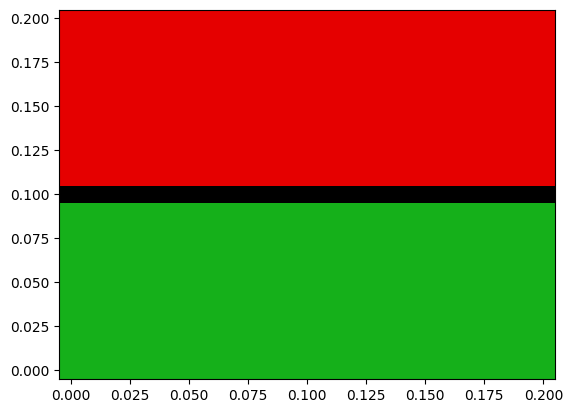

In [95]:
mycmap = ListedColormap(['xkcd:red', 'xkcd:green', 'xkcd:black']) # 0: red, unstable; 1: green, stable
fig, ax = plt.subplots()
im = ax.pcolormesh(xgrid_pi, ygrid_l, grid_stability, vmin=0, vmax=2, cmap=mycmap, shading='nearest')
ax.set(xlabel='$\pi_{1,2}$', ylabel='$\lambda$')

In [18]:
# explore a renge of epsilon, lambdas:
q = 10
eps_lims = (0.0, 0.001)
Neps = 21
l_lims = (0.0, 2/q)
Nls = 21
xgrid_eps, ygrid_l = np.mgrid[eps_lims[0]:eps_lims[1]:complex(0,Neps), l_lims[0]:l_lims[1]:complex(0,Nls)]
xgrid_eps, ygrid_l = np.around(xgrid_eps,4), np.around(ygrid_l,4)
grid_stability = np.empty([Neps, Nls])
for i,eps in enumerate(xgrid_eps[:,0]):
    for j,l in enumerate(ygrid_l[0,:]):
        fstab = stability_f0_eq_1_eps(eps, q, l)
        # if l == 0.1:
        #     print(fstab)
        if fstab == 0.0 or fstab == np.inf or isnan(fstab):
            # print(f'aaaaay: pi = {pi}, l = {l}')
            grid_stability[i,j] = 2 # cumbersome
        elif (fstab < 0):
            grid_stability[i,j] = 1 # stable
        elif (fstab > 0):
            grid_stability[i,j] = 0 # unstable
        # else:
        #     print(f'aaaaay: pi = {pi}, l = {l}')
        #     print(fstab)
        #     grid_stability[i,j] = 2 # cumbersome

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_2626/2455164277.py:18: RuntimeWarning: invalid value encountered in scalar divide
  func = l-r+2*eps*(l+r)/(l-r)
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_2626/2455164277.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  func = l-r+2*eps*(l+r)/(l-r)


[Text(0.5, 0, '$\\epsilon$'), Text(0, 0.5, '$\\lambda$')]

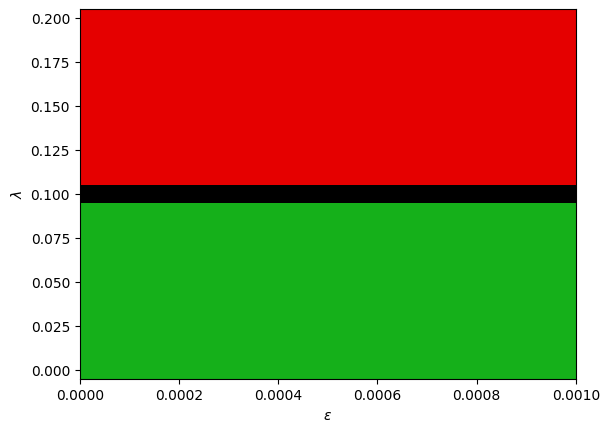

In [21]:
mycmap = ListedColormap(['xkcd:red', 'xkcd:green', 'xkcd:black']) # 0: red, unstable; 1: green, stable
fig, ax = plt.subplots()
im = ax.pcolormesh(xgrid_eps, ygrid_l, grid_stability, vmin=0, vmax=2, cmap=mycmap, shading='nearest')
ax.set(xlabel='$\epsilon$', ylabel='$\lambda$')

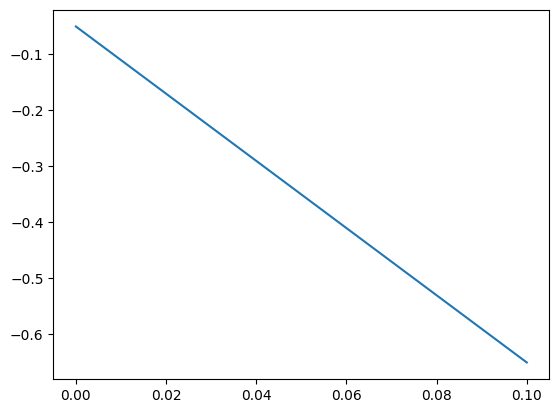

In [22]:
q, l = 10, 0.05
eps = np.linspace(0.0, 0.1, 50)
fig, ax = plt.subplots()

stab = [stability_f0_eq_1_eps(e, q, l) for e in eps]

ax.plot(eps, stab)
    